# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [497]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

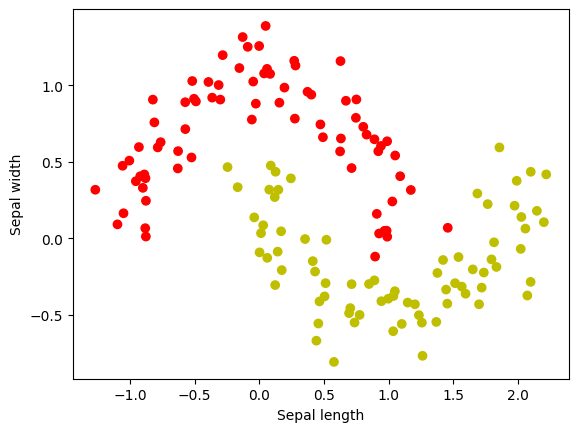

In [498]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [499]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [500]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.Linear(5, 5),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=5, bias=True)
    (2): Linear(in_features=5, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [501]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [502]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [503]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.2689)


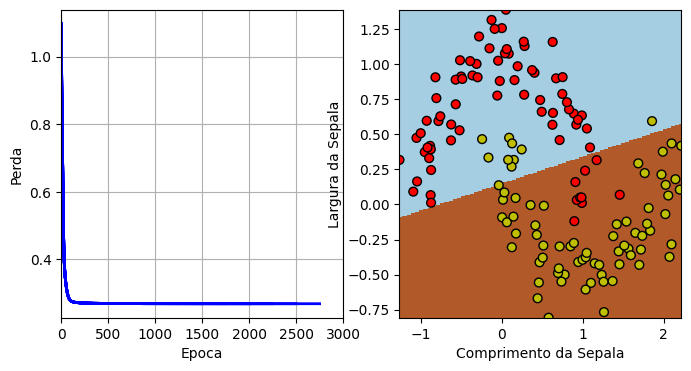

In [504]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [505]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([5, 2])
tensor([[ 0.1816,  0.3923],
        [ 0.1649, -0.7467],
        [-0.1866,  1.2113],
        [ 0.3946, -0.4942],
        [-0.5086,  0.0214]])
dense.0.bias    torch.Size([5])
tensor([-0.2001,  1.1188,  0.8856,  0.5405, -0.4182])
dense.1.weight  torch.Size([5, 5])
tensor([[ 0.1418, -0.2184,  0.8373, -0.1199, -0.0914],
        [ 0.1428, -0.1244, -0.4152, -0.0183, -0.0681],
        [ 0.5412, -0.5922,  0.8345, -0.4073,  0.1825],
        [-0.1075, -0.4163,  0.6555,  0.0806, -0.4255],
        [ 0.2808, -0.9927, -0.5947, -0.2806,  0.6674]])
dense.1.bias    torch.Size([5])
tensor([ 0.2420,  0.2451,  0.1410, -0.1082, -0.9429])
dense.2.weight  torch.Size([3, 5])
tensor([[ 0.9510, -0.1225,  1.0004,  0.5834, -0.4871],
        [-0.1381,  0.0743, -0.5204, -0.1922, -0.9564],
        [-0.0520,  0.1610,  0.1333, -0.0474,  1.1361]])
dense.2.bias    torch.Size([3])
tensor([ 0.4740,  0.5207, -1.2223])


### Avaliação do classificador

In [506]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.88


### Matriz de confusão

In [507]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,66,9
1,9,66


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.
2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.
3. O que ocorre quando não se utiliza ativação não linear entre camadas?

## Principais aprendizados

# 1. O resultado variou muito para as mesmas configurações a cada “Executar tudo” que eu apertava. Isso acontece porque a rede neural é inicializada com pesos aleatórios em cada execução e o problema de otimização é não convexo: dependendo desses pesos iniciais, o gradiente pode convergir para mínimos locais diferentes, gerando perdas finais e fronteiras de decisão diferentes, mesmo com a arquitetura e os hiperparâmetros iguais.

# Mesmo assim, foi possível notar que deixar a primeira camada com menos neurônios que as outras prejudica o desempenho, e que adicionar uma camada pode melhorar a perda, mas adicionar muitas camadas tende a piorar a convergência. Testei essas diferentes profundidades com camadas de 5 e de 10 neurônios e o comportamento geral se repetiu.

# Com isso, concluo que a quantidade ideal de neurônios e de camadas depende do dataset e do objetivo: não existe relação linear entre “mais neurônios/camadas” e melhor desempenho. O equilíbrio entre capacidade e estabilidade do treinamento é o que realmente determina o melhor modelo.

# 2. A perda final aumentou muito e a acurácia do classificador diminuiu porque a Sigmoid faz a rede sofrer com desaparecimento do gradiente (vanishing gradient). Ela satura facilmente, o que impede que os pesos das camadas iniciais sejam atualizados de forma eficaz. Com isso, a rede não consegue aprender uma fronteira de decisão não linear adequada para esse problema, e o classificador acaba produzindo uma separação quase linear entre as classes.

# 3. Sem ativação, a rede é linear por construção. Com Sigmoid, ela poderia ser não linear, mas sofre saturação e vanishing gradient, treinando mal e se comportando, na prática, como um modelo linear. Por isso, nos dois casos a fronteira de decisão acaba sendo praticamente uma reta. Como uma reta não é uma solução adequada para este problema, tanto a rde sem ativação não linear, quanto a com sigmoid tiveram desempenhos ruins